# [BirdCLEF2023](https://www.kaggle.com/competitions/birdclef-2023)


[Inference notebook](https://www.kaggle.com/code/ollypowell/birdclef-2023-pytorch-lightning-inference) 

Original Forks: [Generate spectrograms](https://www.kaggle.com/code/nischaydnk/split-creating-melspecs-stage-1), [Training](https://www.kaggle.com/code/nischaydnk/birdclef-2023-pytorch-lightning-training-w-cmap), [Inference](https://www.kaggle.com/code/nischaydnk/birdclef-2023-pytorch-lightning-inference)


Version 56:  LR 1e-4,  replace head, no pre-training  Identical to 54 but with BCE(reduction='sum')

## Imports

In [1]:
import os
in_kaggle = os.environ.get('PWD') == '/kaggle/working'
if in_kaggle:
    %pip install -q torchtoolbox timm colorednoise
else:
    #working = "/home/olly/Desktop/BirdCLEF23/Kaggle_Kernel/"
    working = "C:/Users/ollyp\Desktop\BirdClef23/Kaggle_Kernel"
    os.chdir(working) # Set to folder containing the data files
print("Current working directory: {0}".format(os.getcwd()))
print(working)

Current working directory: C:\Users\ollyp\Desktop\BirdClef23\Kaggle_Kernel
C:/Users/ollyp\Desktop\BirdClef23/Kaggle_Kernel


In [2]:
import timm 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
import random 
from pathlib import Path
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from sklearn.metrics import confusion_matrix
pio.renderers.default = 'notebook'


# Torch and PyTorch
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint,  EarlyStopping
import torch.nn as nn
from torch.utils.data import  DataLoader
from torch.utils.data.sampler import Sampler
from torch.optim.lr_scheduler import  CosineAnnealingWarmRestarts
import timm

#ML Modules
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as skm
import albumentations as A

#Audio 
import torchaudio
import librosa
import colorednoise as cn

## Configuration

In [3]:
class Config:
    #Training Parameters
    #DEBUG = 200 #shrinks the size of the datasets by that factor, otherwise None
    DEBUG = None
    EXPERIMENT = 66
    NUM_WORKERS = 0
    NUM_CLASSES = 264
    BATCH_SIZE = 32  # was 64 on kaggle, reduced in case of memory errors
    EPOCHS = 24
    PRECISION = 16    
    PATIENCE = 3
    MIN_DELTA = 0
    SEED = 2023
    MODEL = "tf_efficientnetv2_s_in21k"  #Outperformed tf_efficientnetv2_s & tf_efficientnet_b0_ns
    PRETRAINED = True   #Load Efficientnet Weights
    BIRD_TRAINED = False #Additional training on Birdclef21-23
    REPLACE_HEAD = True # Use the BIRD_TRAINED backbone but replace the classifier head
    WEIGHTED_SAMPLING = False 
    WEIGHT_DECAY = 1e-5
    LR = 1e-4
    EPOCHS_TO_UNFREEZE_HEAD = 0  # Only matters if a two-part head
    EPOCHS_TO_UNFREEZE_BACKBONE = 6
    WARMUP_EPOCHS = None
    START_LR = 1e-4  #Not needed if WARMUP_EPOCHS = None
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    LOSS_FUNCTION =  nn.CrossEntropyLoss() #  #nn.BCEWithLogitsLoss() #
    IMAGE_SIZE = 256
    RARE_THRESHOLD = 4
    USE_MIXUP= True
    AUG = 1  # Factor by which to reduce augmentation
    MIXUP_ALPHA = 0.2*AUG
    
    #Train and CV Parameters
    N_FOLDS = 10  # But I'll probably only use one fold initially
    RARE_THRESHOLD = 4 # Samples with less than this many values will not be allowed in valuation

    if in_kaggle:
        MODEL_CKPT = '/kaggle/input/Expt26_Weights/last.ckpt'
        OUT_DIR = '/kaggle/working'
        LABELS_PATH = "/kaggle/input/birdclef23-train-8-sec-wav/train_23_cropped.csv"
        BACKGROUND_NOISE_FLDR = '/kaggle/input/birdclef23-uniform-noise-chunks/birdclef23-backgrounds'
        NOCALLS = '/kaggle/input/birdclef-8-sec-ogg/birdclef-nocall.csv' # must be None or 'some_path'
    else:
        MODEL_CKPT = 'kaggle/input/Expt26_Weights/last.ckpt'  
        OUT_DIR = 'kaggle/working'
        LABELS_PATH = "kaggle/input/birdclef23-detected-8-sec-ogg/birdclef23-selected-labels-multiclass.csv"
        BACKGROUND_NOISE_FLDR = 'kaggle/input/birdclef23-uniform-noise-chunks/birdclef23-backgrounds'
        NOCALLS = 'kaggle/input/birdclef-8-sec-ogg/birdclef-nocall.csv' # must be None or 'some_path'  

In [4]:
class Audio:
    SR = 32000
    DURATION = 5  # Duration the loaded wav file will be cropped to.
    CHUNK_LENGTH = 8 # Maximum duration of the wav files
    N_MELS = 128 # Try increasing this to 256 later, once other experiments tried
    FMIN = 20
    FMAX = 14000
    WINDOW = 1024  
    HOP_LENGTH = 312
    N_FFT = 1024
    PCEN = False
    
    
    # last years 3rd place: two strategies
    # sr: 32000, window_size: 2048, hop_size: 1024, fmin: 200, fmax: 14000, mel_bins: 224
    # sr: 32000, window_size: 1024, hop_size: 512, fmin: 50, fmax: 14000, mel_bins: 128

## Setup

In [5]:
pl.seed_everything(Config.SEED, workers=True)
torch.set_flush_denormal(True)
torch.set_float32_matmul_precision('medium')  # try next time
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')
save_path = Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
Config.PRECISION = 16 if accelerator == 'gpu' else 32
noise = Path(Config.BACKGROUND_NOISE_FLDR)
os.makedirs(save_path, exist_ok=True)
if in_kaggle:
    Audio.BACKGROUNDS = [noise / p for p in noise.rglob('*.wav')] #not sure this would actually work, need to check rglob only returns the file name
else:
    Audio.BACKGROUNDS = [p for p in noise.rglob('*.wav')]
f'There are {len(Audio.BACKGROUNDS)} Audio background files (each made up of concatenated 5 second random clips)'

Global seed set to 2023


'There are 74 Audio background files (each made up of concatenated 5 second random clips)'

Create the train and validation splits using stratified-k-fold to keep the values representative of their class proportions. Later on when the differences are getting smaller and I'm choosing between options, base the CV scheme on 5 folds mean + one standard deviation.  This is too computationaly expensive for now.

In [6]:
use_cols = ['filepath', 'primary_label']
in_df = pd.read_csv(Config.LABELS_PATH,  usecols=use_cols)
if Config.NOCALLS:
    nocall_df = pd.read_csv(Config.NOCALLS, usecols=use_cols)
    in_df = pd.concat([in_df, nocall_df])
if Config.DEBUG is not None:
    in_df = in_df.sample(int(in_df.shape[0]/Config.DEBUG))
Config.NUM_CLASSES = len(in_df.primary_label.unique())
print(f'Training + Validation with {in_df.shape[0]} audio samples')
print(f'There are {Config.NUM_CLASSES} primary class labels')
in_df.head(3)

Training + Validation with 80137 audio samples
There are 265 primary class labels


filepath  \
0  /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_0.ogg   
1  /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_3.ogg   
2  /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_6.ogg   

  primary_label  
0       abethr1  
1       abethr1  
2       abethr1

Temporarily drop any super rare classes from the dataframe, so they don't end up loosing precious samples from training to the validation split.

In [7]:
mask = in_df['primary_label'].map(in_df['primary_label'].value_counts()) > Config.RARE_THRESHOLD
common_df = in_df[mask][['primary_label', 'filepath']]
mask = in_df['primary_label'].map(in_df['primary_label'].value_counts()) <= Config.RARE_THRESHOLD
rare_df = in_df[mask][['primary_label', 'filepath']]
rare_df.primary_label.value_counts()

rehblu1    4
lotlap1    3
golher1    2
whctur2    2
whhsaw1    2
afpkin1    1
Name: primary_label, dtype: int64

In [8]:
print(f'Temporarily removing {rare_df.shape[0]} rare instances from the dataset before splitting because'
      f' they have less than or equal to {Config.RARE_THRESHOLD} audio samples per class')

Temporarily removing 14 rare instances from the dataset before splitting because they have less than or equal to 4 audio samples per class


In [9]:
splits = 4 if Config.DEBUG else Config.N_FOLDS
skf =StratifiedKFold(n_splits=splits, shuffle=True, random_state=Config.SEED)
target = common_df['primary_label'] 

for train_index, val_index in skf.split(common_df, target):
    train_df, val_df = common_df.iloc[train_index], common_df.iloc[val_index]
train_df = pd.concat([train_df, rare_df])
    
print(f'The training dataframe has {train_df.shape[0]} rows\n'
      f'The validation dataframe has {val_df.shape[0]} rows')

The training dataframe has 72125 rows
The validation dataframe has 8012 rows


In [10]:
# Specifically check the filename column
train_df.head()

primary_label  \
0       abethr1   
1       abethr1   
2       abethr1   
3       abethr1   
4       abethr1   

                                                                  filepath  
0   /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_0.ogg  
1   /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_3.ogg  
2   /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_6.ogg  
3   /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_9.ogg  
4  /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_12.ogg

Create & Fill birds with 0 samples in validation.  This is only needed because of the get-dummies approach with the dataframes.  The validation df misses out on columns for the missing species.  I also considered up-sampling the rare species, and ensuring one of the extra samples from each would go into the validation dataframe, but this would likely result in over-estimating the validation performance, and potentially over-fitting.

In [11]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['primary_label'])], axis=1)
val_df = pd.concat([val_df, pd.get_dummies(val_df['primary_label'])], axis=1)
train_df.head(3)

primary_label  \
0       abethr1   
1       abethr1   
2       abethr1   

                                                                 filepath  \
0  /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_0.ogg   
1  /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_3.ogg   
2  /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_6.ogg   

   abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  affeag1  afgfly1  \
0        1        0        0        0        0        0        0        0   
1        1        0        0        0        0        0        0        0   
2        1        0        0        0        0        0        0        0   

   ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  yertin1  yesbar1  yespet1  \
0  ...        0        0       0        0        0        0        0        0   
1  ...        0        0       0        0        0        0        0        0   
2  ...        0        0       0        0        0        0        0        0   

   yetgre1  yewgre1  
0        0        0  
1        0        0  
2        0        0  

[3 rows x 267 columns]

In [12]:
birds = list(train_df.primary_label.unique())
missing_birds = list(set(list(train_df.primary_label.unique())).difference(list(val_df.primary_label.unique())))
non_missing_birds = list(set(list(train_df.primary_label.unique())).difference(missing_birds))
val_df[missing_birds] = 0
val_df = val_df[train_df.columns] ## Fix order
len(non_missing_birds)
val_df.head(3)

primary_label  \
5        abethr1   
7        abethr1   
38       abethr1   

                                                                   filepath  \
5   /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_15.ogg   
7   /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC128013_21.ogg   
38  /kaggle/input/birdclef23-detected-8-sec-ogg/train_audio/XC363503_15.ogg   

    abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  affeag1  afgfly1  \
5         1        0        0        0        0        0        0        0   
7         1        0        0        0        0        0        0        0   
38        1        0        0        0        0        0        0        0   

    ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  yertin1  yesbar1  \
5   ...        0        0       0        0        0        0        0   
7   ...        0        0       0        0        0        0        0   
38  ...        0        0       0        0        0        0        0   

    yespet1  yetgre1  yewgre1  
5         0        0        0  
7         0        0        0  
38        0        0        0  

[3 rows x 267 columns]

Helper functions and classes

In [13]:
def load_sf(wav_path, sr=Audio.SR):
    y, _ = librosa.load(wav_path, sr=sr)
    return y
    

def compute_pcen(y):
    if not np.isfinite(y).all():
        y[np.isnan(y)] = np.zeros_like(y)
        y[np.isinf(y)] = np.max(y)
    melspec = librosa.feature.melspectrogram(y=y, sr=Audio.SR, n_mels=Audio.N_MELS, n_fft= Audio.N_FFT, fmin=Audio.FMIN, fmax=Audio.FMAX)
    pcen = librosa.pcen(melspec, sr=Audio.SR, gain=0.98, bias=2, power=0.5, time_constant=0.4, eps=0.000001).astype(np.float32)
    return pcen


def compute_melspec(y):
    if not np.isfinite(y).all():
        y[np.isnan(y)] = np.zeros_like(y)
        y[np.isinf(y)] = np.max(y)
    melspec = librosa.feature.melspectrogram(y=y, sr=Audio.SR, n_mels=Audio.N_MELS, n_fft=Audio.N_FFT, hop_length = Audio.HOP_LENGTH, fmin=Audio.FMIN, fmax=Audio.FMAX)
    melspec = librosa.power_to_db(melspec)  #.astype(np.float32)
    return melspec


def mono_to_color(X, eps=1e-6, mean=None, std=None):
    _min, _max = X.min(), X.max()
    if (_max - _min) > eps:
        X = (X - _min) / (_max - _min) #scales to a range of [0,1]
        X = X.astype(np.float32)
    else:
        X = np.zeros_like(X, dtype=np.float32)
    X = np.stack([X, X, X], axis=-1) #puts the chanels last, like a normal image, for the ablu_trasformations
    return X


def crop_or_pad(y, length, train='train'):
    y = np.concatenate([y, y, y])
    if len(y) <= length:
        n_repeats = length // len(y)
        epsilon = length % len(y)
        y = np.concatenate([y]*n_repeats + [y[:epsilon]]) 
    else:
        if train != 'train':
            start = 0
        else:
            start = np.random.randint(len(y) - length)
        y = y[start: start + length]
    return y

def random_crop(arr, length):
    start = np.random.randint(len(arr) - length)
    arr = arr[start: start + length]
    return arr


def reshape_image(arr):  #chop the image in half along the long dimension and stack to make more square
    cols = arr.shape[1]//2 
    remainder = arr.shape[1] % 2
    half1 = arr[:, :cols + remainder]
    half2 = arr[:, cols:]
    
    if np.random.choice([True,False], size=1)[0]:
        arr =  np.vstack((half1, half2))
    else:
        arr = np.vstack((half2, half1))
    return arr

In [14]:
class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray, sr):
        for trns in self.transforms:
            y = trns(y, sr)
        return y


class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray, sr):
        if self.always_apply:
            return self.apply(y, sr=sr)
        else:
            if np.random.rand() < self.p:
                return self.apply(y, sr=sr)
            else:
                return y

    def apply(self, y: np.ndarray, **params):
        raise NotImplementedError


class OneOf(Compose):
    def __init__(self, transforms, p=0.5):
        super().__init__(transforms)
        self.p = p
        transforms_ps = [t.p for t in transforms]
        s = sum(transforms_ps)
        self.transforms_ps = [t / s for t in transforms_ps]

    def __call__(self, y: np.ndarray, sr):
        data = y
        if self.transforms_ps and (np.random.random() < self.p):
            random_state = np.random.RandomState(np.random.randint(0, 2 ** 16 - 1))
            t = random_state.choice(self.transforms, p=self.transforms_ps)
            data = t(y, sr)
        return data


class Normalize(AudioTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply, p)

    def apply(self, y: np.ndarray, **params):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)


class NoiseInjection(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_level=0.5):
        super().__init__(always_apply, p)

        self.noise_level = (0.0, max_noise_level)

    def apply(self, y: np.ndarray, **params):
        noise_level = np.random.uniform(*self.noise_level)
        noise = np.random.randn(len(y))
        augmented = (y + noise * noise_level).astype(y.dtype)
        return augmented


class GaussianNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise ** 2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented

#https://github.com/felixpatzelt/colorednoise
class PinkNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise ** 2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented

#https://github.com/felixpatzelt/colorednoise
class BrownNoise(AudioTransform):       #Added in V2
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        brown_noise = cn.powerlaw_psd_gaussian(2, len(y))
        a_brown = np.sqrt(brown_noise ** 2).max()
        augmented = (y + brown_noise * 1 / a_brown * a_noise).astype(y.dtype)
        return augmented

    
#https://www.kaggle.com/code/hidehisaarai1213/rfcx-audio-data-augmentation-japanese-english
#https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6
class AddBackround(AudioTransform):
    def __init__(self, always_apply=False, p=0.6, min_snr=1, max_snr=20, background_pths=Audio.BACKGROUNDS, sr=Audio.SR, duration=Audio.DURATION):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr
        self.back_pths = Audio.BACKGROUNDS
        self.background = load_sf(random.choice(Audio.BACKGROUNDS))
        self.d_len = duration * sr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        if random.random() < 0.05:  #load a new background file roughly every 20th sample
            background_path = random.choice(Audio.BACKGROUNDS)
            #print(background_path)
            self.background = load_sf(background_path)
        background = random_crop(self.background, self.d_len)

        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))  
        l_signal = len(y)


        a_background = np.sqrt(background ** 2).max()
        l_background = len(background)

        if l_signal > l_background:
            ratio = l_signal//l_background
            background = np.tile(background, ratio+1 )
            background = background[0:l_signal]

        if l_signal < l_background:    
            background = background[0:l_signal]

        augmented = (y + background * 1 / a_background * a_noise).astype(y.dtype)
        return augmented    


def spec_augment(spec: np.ndarray, num_mask=2, freq_masking_max_percentage=0.15, time_masking_max_percentage=0.1, p=0.5):
    if random.uniform(0, 1) > p:
        return spec
    
    #spec = spec.copy()

    # frequency masking
    num_freq_masks = random.randint(1, num_mask)
    for i in range(num_freq_masks):
        freq_percentage = random.uniform(0, freq_masking_max_percentage)
        freq_mask_size = int(freq_percentage * spec.shape[0])
        freq_mask_pos = random.randint(0, spec.shape[0] - freq_mask_size)
        spec[freq_mask_pos:freq_mask_pos+freq_mask_size, :] = 0

    # time masking
    num_time_masks = random.randint(1, num_mask)
    for i in range(num_time_masks):
        time_percentage = random.uniform(0, time_masking_max_percentage)
        time_mask_size = int(time_percentage * spec.shape[1])
        time_mask_pos = random.randint(0, spec.shape[1] - time_mask_size)
        spec[:, time_mask_pos:time_mask_pos+time_mask_size] = 0

    return spec



mean = (0.485, 0.456, 0.406) # RGB
std = (0.229, 0.224, 0.225) # RGB
albu_transforms = {
    'train' : A.Compose([
            A.Normalize(mean, std, max_pixel_value=1.0,always_apply=True),
            A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=.4*Config.AUG),
            A.PadIfNeeded(min_height=Config.IMAGE_SIZE, min_width=Config.IMAGE_SIZE),
            A.RandomCrop(width=Config.IMAGE_SIZE, height=Config.IMAGE_SIZE),      
    ]),
    'valid' :  A.Compose([
                A.Normalize(mean, std, max_pixel_value=1.0,always_apply=True),
                A.PadIfNeeded(min_height=Config.IMAGE_SIZE, min_width=Config.IMAGE_SIZE),
                A.RandomCrop(width=Config.IMAGE_SIZE, height=Config.IMAGE_SIZE),  
        ])
}

In [15]:
class WaveformDataset(torch.utils.data.Dataset):

    def __init__(self, df, sr = Audio.SR, duration = Audio.DURATION, chunk=Audio.CHUNK_LENGTH, train=True):
        
        self.df = df
        self.sr = sr 
        self.train = train
        self.mode = 'train' if train else 'valid'
        self.d_len = duration * self.sr
        self.c_len = chunk * self.sr
        

    #With nnAudio n_bins=None, the frequency bins default to n_fft/2 + 1 =513 with a 1024 window, which is optimal, but with hop lenth 512
    #we end up with a 501x513 image, which iss too big for CUDA memory.  So downsampling is needed in the f axis by specifying n_bins
    #513 x 313 images would also be too slow for inferance. Could consider 256x313 if that gives a performance gain.  Better still try
    #to get a square 256x256 or 224 x 224 image
        
        if self.train:
            self.wave_transforms = Compose(
                [
                    OneOf(
                        [
                            NoiseInjection(p=.5, max_noise_level=0.04),
                            GaussianNoise(p=.5, min_snr=2, max_snr=20),
                            PinkNoise(p=.5, min_snr=2, max_snr=20),
                            BrownNoise(p=.5, min_snr=2, max_snr=20),
                        ],
                        p=0.5*Config.AUG,
                    ),
                    AddBackround(p=0.5*Config.AUG, min_snr=1*Config.AUG, max_snr=20),
                    Normalize(p=1),
                ]
            )
        else:
            self.wave_transforms = Normalize(p=1)
        
    def __len__(self):
        return self.df.shape[0]

    
    def __getitem__(self, idx):    
        row = self.df.iloc[idx]
        wav_path = row.filepath 
        if not in_kaggle:
            wav_path = wav_path.lstrip('/')
        y, _ = torchaudio.load(wav_path)
        y = y.squeeze().numpy()   #Faster to use torchaudio, but anyway the bottleneck is with the STFT not loading
        if not np.isfinite(y).all():
            y[np.isnan(y)] = np.mean(y)
            y[np.isinf(y)] = np.mean(y)
        
        if len(y) > 0: 
            y = y[:self.c_len]  
        y = crop_or_pad(y, self.d_len, train=self.train)     
        y = self.wave_transforms(y, sr=self.sr)

        if Audio.PCEN: 
            image = compute_pcen(y)
        else:
            image = compute_melspec(y)
            
        if self.train:
            image = spec_augment(image, p=0.5*Config.AUG, num_mask=2, freq_masking_max_percentage=0.05, time_masking_max_percentage=0.05)
        image = reshape_image(image)
        image = mono_to_color(image)
        image = albu_transforms[self.mode](image=image)['image']#[:,:,0]  # replace with spec_augment
        image = image.transpose(2,0,1).astype(np.float32) # swapping the image channels to the first axis
        targets = torch.tensor(row[2:]).float().to(torch.float32)
        return image, targets

In [16]:
class InverseSqrtSampler(Sampler):
    def __init__(self, targets_df, replacement=True):
        targets_numeric = targets_df.select_dtypes(include='number')  # Select only numeric columns
        self.targets = np.argmax(targets_numeric.values, axis=1)
        self.class_counts = np.bincount(self.targets)
        self.weights = 1.0 / np.sqrt(self.class_counts)
        self.weights = self.weights / self.weights.sum()
        self.indices = np.arange(len(targets_df))
        self.replacement = replacement

    def __iter__(self):
        indices = []
        for class_idx in range(len(self.class_counts)):
            class_indices = self.indices[self.targets == class_idx]
            class_sampler = torch.utils.data.sampler.WeightedRandomSampler(
                self.weights[class_idx] * np.ones(len(class_indices)),
                len(class_indices),
                replacement=self.replacement
            )
            indices += [class_indices[i] for i in class_sampler]
        return iter(indices)

    def __len__(self):
        return len(self.indices)

In [17]:
def get_fold_dataloaders(df_train, df_valid):

    ds_train = WaveformDataset(
        df_train, 
        sr = Audio.SR,
        duration = Audio.DURATION,
        train = True)
    
    ds_val = WaveformDataset(
        df_valid, 
        sr = Audio.SR,
        duration = Audio.DURATION,
        train=False)
    
    if Config.WEIGHTED_SAMPLING:
        sampler = InverseSqrtSampler(df_train, replacement=True)
        dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE , sampler=sampler, num_workers=Config.NUM_WORKERS)   
    else:
        dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE , shuffle=True, num_workers=Config.NUM_WORKERS) 

    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers = Config.NUM_WORKERS)   

    return dl_train, dl_val, ds_train, ds_val

In [18]:
def show_batch(img_ds, num_rows, num_cols, predict_arr=None):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, len(img_ds)-1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first 9 images
        img, lb = img_ds[index]
        shape=img.shape
        print(shape)
        scaled_data = (img[0] - np.min(img[0])) / (np.max(img[0]) - np.min(img[0]))
        img = librosa.display.specshow(scaled_data, x_axis='time', y_axis='mel', ax=ax)
        ax.set(title= f'Spectrogram {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")        

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


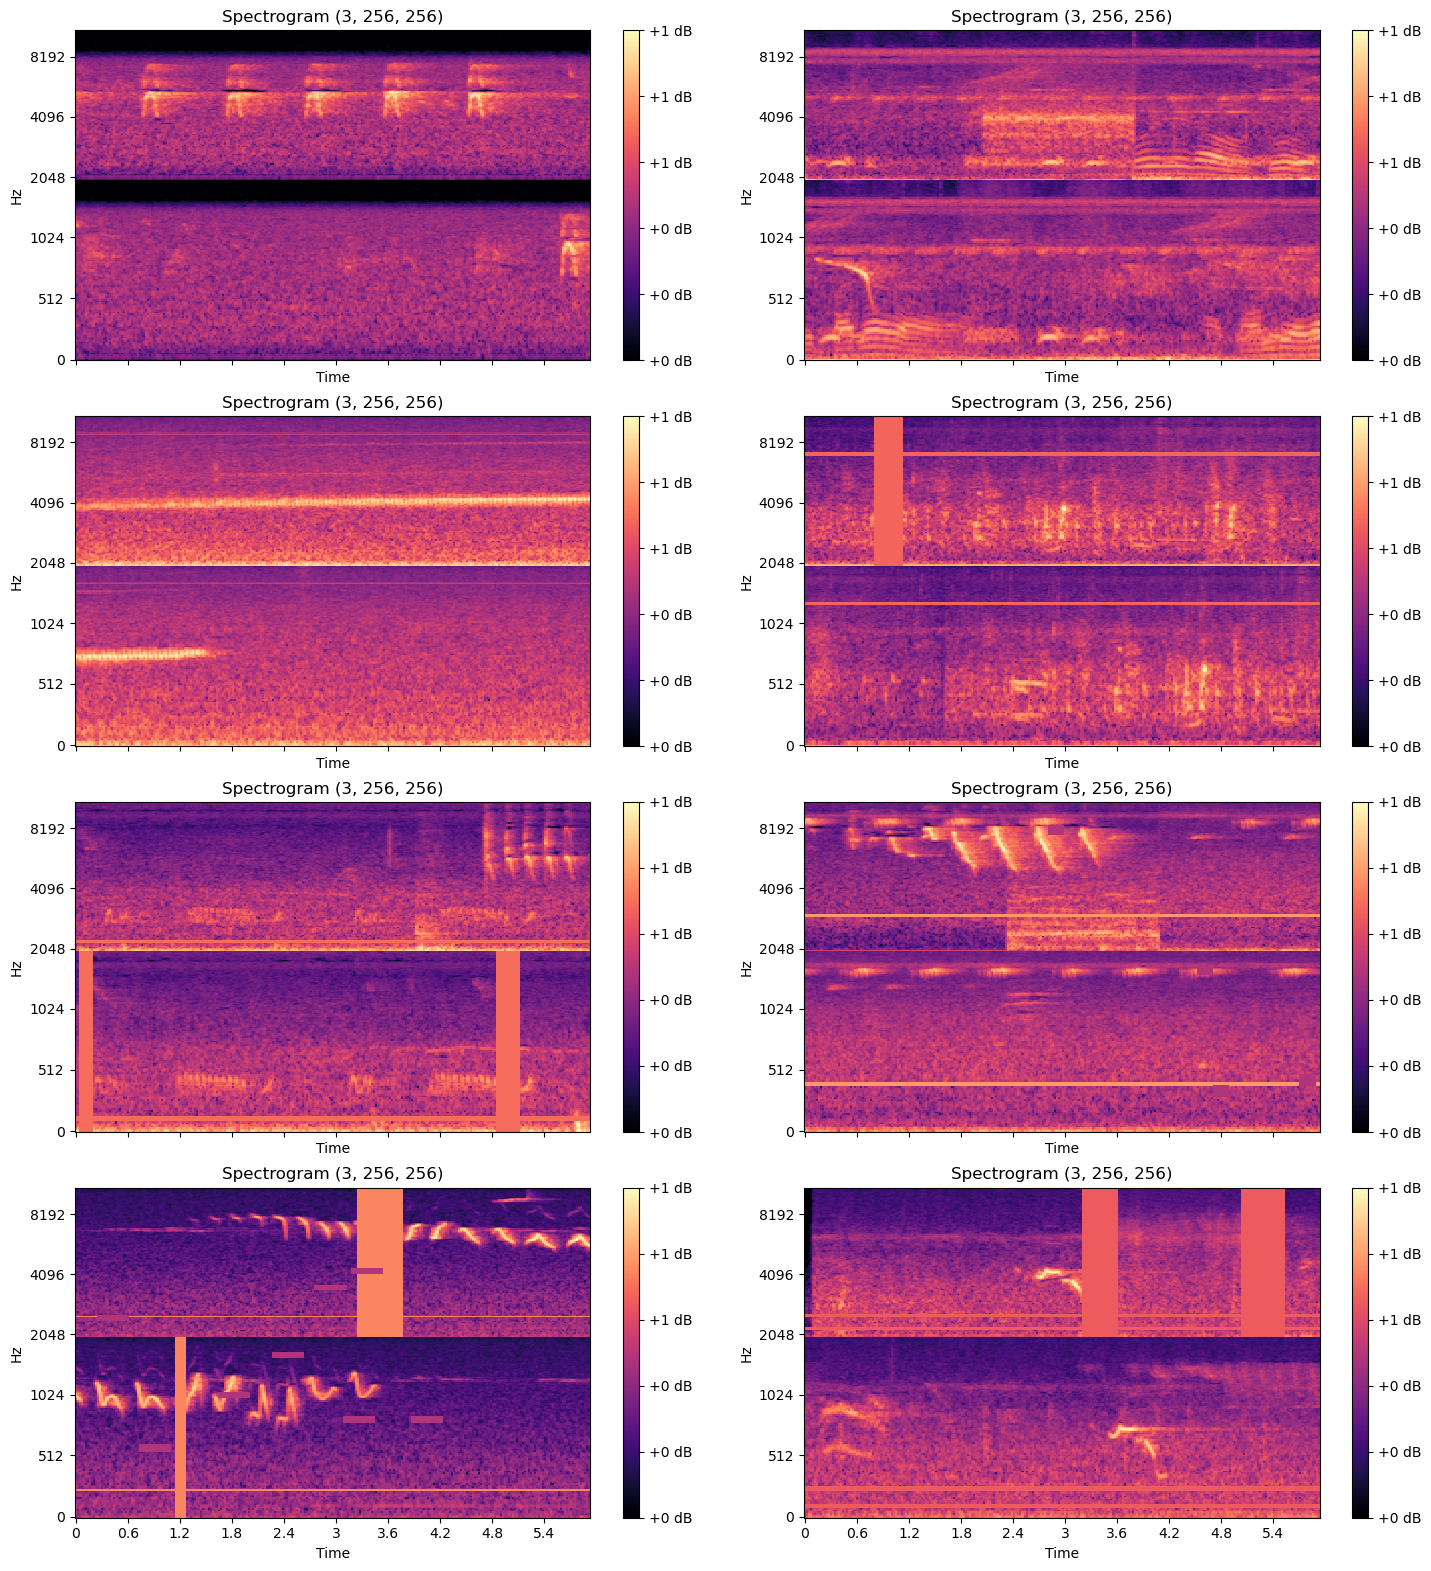

In [19]:
dl_train, dl_val, ds_train, ds_val = get_fold_dataloaders(train_df, val_df)
show_batch(ds_train, 4, 2)

In [20]:
def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.WEIGHT_DECAY )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.EPOCHS, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1)
    
    return { "optimizer": model_optimizer, 
             "lr_scheduler": {"scheduler": lr_scheduler,
                        "interval": interval,
                        "monitor": "val_loss",
                        "frequency": 1}}

In [21]:
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution.fillna(0).replace([pd.np.inf, -pd.np.inf], 0)
    submission = submission.fillna(0).replace([pd.np.inf, -pd.np.inf], 0)
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = skm.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro')    
    return score


def padded_cmap_by_class(solution, submission, padding_factor=5):
    solution = solution.fillna(0).replace([np.inf, -np.inf], 0)
    submission = submission.fillna(0).replace([np.inf, -np.inf], 0)
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    
    column_headers = list(solution.columns)
    scores = {}
    
    for column in column_headers:
        score = skm.average_precision_score(
            padded_solution[[column]].values,
            padded_submission[[column]].values,
            average='macro')    
        scores[column] = score
    return scores


def map_score(solution, submission):
    solution = solution.fillna(0).replace([pd.np.inf, -pd.np.inf], 0)
    submission = submission.fillna(0).replace([pd.np.inf, -pd.np.inf], 0)
    score = skm.average_precision_score(
        solution.values,
        submission.values,
        average='micro')  
    return score


def mixup_data(x, y, alpha=1.0, device=device):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [22]:
# Testing Validation Strategy
dummy = val_df[birds].copy()
dummy[birds] = np.random.rand(dummy.shape[0],dummy.shape[1])
pad_5 = padded_cmap(val_df[birds], dummy[birds], padding_factor = 5)
pad_1 = padded_cmap(val_df[birds], dummy[birds], padding_factor = 1)

print(f'Padded cMAP, with padding=5: {pad_5}\n'
     f'Padded cMAP, with padding=1: {pad_1}\n'
     f'MAP score: {map_score(val_df[birds], dummy[birds])}')

Padded cMAP, with padding=5: 0.23699357301998933
Padded cMAP, with padding=1: 0.09150519501198508
MAP score: 0.0038125834710112274


In [23]:
class ClassifierHead(nn.Module):
    def __init__(self, num_features, num_classes, dropout_rate=0.35):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.output_layer = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        x = self.relu(x)  # This was missing the x= !   Try again with that fixed
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [24]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, 
                 model_name=Config.MODEL, 
                 num_classes = Config.NUM_CLASSES,
                 pretrained = Config.PRETRAINED, 
                 bird_trained = Config.BIRD_TRAINED,
                 replace_head = Config.REPLACE_HEAD,
                 loss=Config.LOSS_FUNCTION,
                 unfreeze=Config.EPOCHS_TO_UNFREEZE_HEAD,
                 unfreeze_backbone=Config.EPOCHS_TO_UNFREEZE_BACKBONE,
                 checkpoint_path=None):
        super().__init__()
        
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(nn.Linear(self.in_features, self.in_features))  # 769 from pre-training incl. no-call

        if bird_trained:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            self.backbone.load_state_dict(checkpoint['state_dict'], strict=False)
        if replace_head:
            self.backbone.classifier = nn.Sequential(nn.Linear(self.in_features, self.num_classes)) 
            for param in self.backbone.classifier.parameters():
                param.requires_grad = True
        else:
            for param in self.backbone.parameters():
                param.requires_grad = False
            self.new_head = ClassifierHead(self.in_features, self.num_classes)    
            self.backbone.classifier = nn.Sequential(self.backbone.classifier, self.new_head)  #only new parts unfrozen initially  seems like a good idea, but doesn't work

        self.loss_function = loss
        self.val_outputs = []
        self.train_outputs = []
        self.metrics_list = []
        self.val_epoch = 0
        self.epoch_to_unfreeze_head = unfreeze
        self.epoch_to_unfreeze_backbone = unfreeze_backbone

        #self.current_epoch = 0
            
    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        if Config.WARMUP_EPOCHS and Config.WARMUP_EPOCHS > self.trainer.current_epoch:
            current_lr = Config.START_LR + (Config.LR - Config.START_LR) * (self.trainer.current_epoch / Config.WARMUP_EPOCHS)
        else:
            current_lr = Config.LR
        return get_optimizer(lr=current_lr, params=self.parameters())
    

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.MIXUP_ALPHA)
        y_pred = self(X)
        loss_mixup = mixup_criterion(self.loss_function, y_pred, y_a, y_b, lam)
        return loss_mixup, y_pred

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.USE_MIXUP:
            loss, y_pred = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        train_output = {"train_loss": loss, "logits": y_pred, "targets": target}
        self.train_outputs.append(train_output) 
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        output = {"val_loss": val_loss, "logits": y_pred, "targets": target}  #new line
        self.val_outputs.append(output)  #new line
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
       
    def on_validation_epoch_end(self):  #breaks with these two lines in
        val_outputs = self.val_outputs
        avg_val_loss = torch.stack([x['val_loss'] for x in val_outputs]).mean().cpu().detach().numpy()
        output_val_logits = torch.cat([x['logits'] for x in val_outputs],dim=0)
        val_targets = torch.cat([x['targets'] for x in val_outputs],dim=0).cpu().detach().numpy() 
        
        train_outputs = self.train_outputs
        if train_outputs:
            train_losses = [x['train_loss'].cpu().detach().numpy() for x in train_outputs]
            avg_train_loss = sum(train_losses) / len(train_losses) if train_losses else 0.0
            output_train_logits = torch.cat([x['logits'] for x in train_outputs],dim=0)
            train_targets = torch.cat([x['targets'] for x in train_outputs],dim=0).cpu().detach().numpy()
        else: 
            avg_train_loss = avg_val_loss #we need this because the first time it's an empty list
            output_train_logits = torch.ones(1,output_val_logits.shape[1])
            train_targets = torch.zeros(1, output_val_logits.shape[1])
            
    
        
        if Config.LOSS_FUNCTION == nn.CrossEntropyLoss():
            val_probs = F.softmax(output_val_logits, dim=1).cpu().detach().numpy()
            train_probs = F.softmax(output_train_logits, dim=1).cpu().detach().numpy()
        else:
            val_probs = output_val_logits.sigmoid().cpu().detach().numpy()
            train_probs = output_train_logits.sigmoid().cpu().detach().numpy()
  
        val_pred_df = pd.DataFrame(val_probs, columns = birds)
        val_target_df = pd.DataFrame(val_targets, columns = birds)
        train_pred_df = pd.DataFrame(train_probs, columns = birds)
        train_target_df = pd.DataFrame(train_targets, columns = birds)
       
        avg_score = padded_cmap(val_target_df, val_pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_target_df, val_pred_df, padding_factor = 3)
        avg_score3 = skm.label_ranking_average_precision_score(val_targets,val_probs)        
        
        if self.val_epoch > 0:
            avg_score4 = padded_cmap(train_target_df, train_pred_df, padding_factor = 5)
            self.metrics_list.append({'train_loss':avg_train_loss, 'val_loss': avg_val_loss, 'val_prec':avg_score3, 'train_prec':avg_score4, })
        
        # competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} train loss {avg_train_loss}')
        print(f'epoch {self.current_epoch} validation loss {avg_val_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3 or None}')
        
        val_target_df.to_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_target_df.pkl')
        val_pred_df.to_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_pred_df.pkl') 
        train_target_df.to_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_target_df.pkl')
        train_pred_df.to_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_pred_df.pkl')  
        
        self.val_outputs = []
        self.train_outputs = []
        self.val_epoch +=1
    
        return
    
    def on_train_epoch_end(self, *args, **kwargs):
        if self.current_epoch == self.epoch_to_unfreeze_head:
        # Unfreeze the old classifier head
            for param in self.backbone.classifier.parameters():
                param.requires_grad = True
            #Consider creating a new optimiser at this point, like this:
            #self.optimizer = torch.optim.Adam([
                #{'params': self.backbone.parameters(), 'lr': 1e-5},
                #{'params': self.new_head.parameters(), 'lr': 1e-4}])
        
        if self.current_epoch == self.epoch_to_unfreeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = True
            print(f'Unfreezing the backbone after {self.current_epoch} epochs')
    
    def get_my_metrics_list(self):
        return self.metrics_list

In [25]:
# Load the checkpoint
if Config.BIRD_TRAINED:
    checkpoint = torch.load(Config.MODEL_CKPT)
    # Print the architecture of the checkpoint
    print(checkpoint.keys())

In [26]:
def run_training():
    print(f"Running training...")
    logger = None
    dl_train, dl_val, _, _ = get_fold_dataloaders(train_df, val_df)
    audio_model = BirdClefModel(checkpoint_path=Config.MODEL_CKPT)

    early_stop_callback = EarlyStopping(monitor="val_loss", 
                                        min_delta=Config.MIN_DELTA, 
                                        patience=Config.PATIENCE, 
                                        verbose= True, 
                                        mode="min")
    
    # saves top- checkpoints based on "val_loss" metric
    checkpoint_callback = ModelCheckpoint(save_top_k=10,
                                          monitor="val_loss",
                                          mode="min",
                                          dirpath=save_path,
                                          save_last= True,
                                          save_weights_only=True, 
                                          verbose= True,
                                          #filename=f'birdCLEF23-{epoch:02d}-{val_loss:.4f}',  need to figure this out so It can update to a dataset
)
    
    callbacks_to_use = [checkpoint_callback, early_stop_callback] #MonitoringCallback   # work more on this later.
    
    
    trainer = pl.Trainer(
        gpus=1,
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.EPOCHS,
        logger=logger,
        auto_lr_find=False,    
        callbacks=callbacks_to_use,
        precision=Config.PRECISION, accelerator=accelerator)

    
    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_val)       
    gc.collect()
    torch.cuda.empty_cache()
    
    return audio_model.get_my_metrics_list()

In [27]:
metrics = run_training()


Running training...


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | backbone      | EfficientNet     | 20.5 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
20.5 M    Trainable params
0         Non-trainable params
20.5 M    Total params
41.034    Total estimated model params size (MB)


Running trainer.fit


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 train loss 5.216278076171875
epoch 0 validation loss 5.216278076171875
epoch 0 validation C-MAP score pad 5 0.9972733342759953
epoch 0 validation C-MAP score pad 3 0.996553908217507
epoch 0 validation AP score 0.047762412470552476


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch 0 train loss 3.9482417322410983
epoch 0 validation loss 2.128913164138794
epoch 0 validation C-MAP score pad 5 0.644890856690762
epoch 0 validation C-MAP score pad 3 0.60205001171965
epoch 0 validation AP score 0.6489728635022517


Metric val_loss improved. New best score: 2.132
Epoch 0, global step 1127: 'val_loss' reached 2.13242 (best 2.13242), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=0-step=1127.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 0 train loss 2.5411605486429787
epoch 0 validation loss 1.3291984796524048
epoch 0 validation C-MAP score pad 5 0.7845139148950824
epoch 0 validation C-MAP score pad 3 0.757222040546586
epoch 0 validation AP score 0.7929635444633927


Metric val_loss improved by 0.802 >= min_delta = 0. New best score: 1.331
Epoch 0, global step 2254: 'val_loss' reached 1.33059 (best 1.33059), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=0-step=2254.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 1 train loss 1.960482916344344
epoch 1 validation loss 0.9951644539833069
epoch 1 validation C-MAP score pad 5 0.8480973717001168
epoch 1 validation C-MAP score pad 3 0.8287596526637353
epoch 1 validation AP score 0.8519669012719433


Metric val_loss improved by 0.334 >= min_delta = 0. New best score: 0.996
Epoch 1, global step 3381: 'val_loss' reached 0.99647 (best 0.99647), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=1-step=3381.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 1 train loss 1.7832046036394487
epoch 1 validation loss 0.8499129414558411
epoch 1 validation C-MAP score pad 5 0.8821780976830021
epoch 1 validation C-MAP score pad 3 0.8673322303957762
epoch 1 validation AP score 0.8869236672131795


Metric val_loss improved by 0.146 >= min_delta = 0. New best score: 0.851
Epoch 1, global step 4508: 'val_loss' reached 0.85087 (best 0.85087), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=1-step=4508.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 2 train loss 1.5017599650553717
epoch 2 validation loss 0.7054378986358643
epoch 2 validation C-MAP score pad 5 0.8997340618970513
epoch 2 validation C-MAP score pad 3 0.88754095137185
epoch 2 validation AP score 0.9076452630528631


Metric val_loss improved by 0.145 >= min_delta = 0. New best score: 0.706
Epoch 2, global step 5635: 'val_loss' reached 0.70623 (best 0.70623), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=2-step=5635.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 2 train loss 1.4830340765542231
epoch 2 validation loss 0.6024441123008728
epoch 2 validation C-MAP score pad 5 0.9141385049405706
epoch 2 validation C-MAP score pad 3 0.9037197303448423
epoch 2 validation AP score 0.922826134765549


Metric val_loss improved by 0.104 >= min_delta = 0. New best score: 0.602
Epoch 2, global step 6762: 'val_loss' reached 0.60224 (best 0.60224), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=2-step=6762.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 3 train loss 1.2982984496133456
epoch 3 validation loss 0.5612979531288147
epoch 3 validation C-MAP score pad 5 0.9190560105562687
epoch 3 validation C-MAP score pad 3 0.909991608153156
epoch 3 validation AP score 0.9306899358744485


Metric val_loss improved by 0.041 >= min_delta = 0. New best score: 0.561
Epoch 3, global step 7889: 'val_loss' reached 0.56115 (best 0.56115), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=3-step=7889.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 3 train loss 1.237403180618781
epoch 3 validation loss 0.5458709001541138
epoch 3 validation C-MAP score pad 5 0.9269362562277244
epoch 3 validation C-MAP score pad 3 0.91829170768181
epoch 3 validation AP score 0.9369945828458088


Metric val_loss improved by 0.015 >= min_delta = 0. New best score: 0.546
Epoch 3, global step 9016: 'val_loss' reached 0.54607 (best 0.54607), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=3-step=9016.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 4 train loss 1.1831630855540893
epoch 4 validation loss 0.512773334980011
epoch 4 validation C-MAP score pad 5 0.9298505542704821
epoch 4 validation C-MAP score pad 3 0.92200899530813
epoch 4 validation AP score 0.9427336313970176


Metric val_loss improved by 0.034 >= min_delta = 0. New best score: 0.512
Epoch 4, global step 10143: 'val_loss' reached 0.51239 (best 0.51239), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=4-step=10143.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 4 train loss 1.1769109693584763
epoch 4 validation loss 0.44945475459098816
epoch 4 validation C-MAP score pad 5 0.9341252566270623
epoch 4 validation C-MAP score pad 3 0.9269744926264346
epoch 4 validation AP score 0.9480062695855935


Metric val_loss improved by 0.064 >= min_delta = 0. New best score: 0.449
Epoch 4, global step 11270: 'val_loss' reached 0.44882 (best 0.44882), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=4-step=11270.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 5 train loss 1.134819152833565
epoch 5 validation loss 0.43911805748939514
epoch 5 validation C-MAP score pad 5 0.9303302573871929
epoch 5 validation C-MAP score pad 3 0.9230149274592899
epoch 5 validation AP score 0.9514889148657292


Metric val_loss improved by 0.010 >= min_delta = 0. New best score: 0.439
Epoch 5, global step 12397: 'val_loss' reached 0.43886 (best 0.43886), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=5-step=12397.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 5 train loss 1.0932928951194356
epoch 5 validation loss 0.4113999009132385
epoch 5 validation C-MAP score pad 5 0.9351223004410497
epoch 5 validation C-MAP score pad 3 0.9280795767767196
epoch 5 validation AP score 0.9539948807618385


Metric val_loss improved by 0.028 >= min_delta = 0. New best score: 0.411
Epoch 5, global step 13524: 'val_loss' reached 0.41100 (best 0.41100), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=5-step=13524.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 6 train loss 1.0684613362384403
epoch 6 validation loss 0.42006200551986694
epoch 6 validation C-MAP score pad 5 0.9352740424520946
epoch 6 validation C-MAP score pad 3 0.928453171793463
epoch 6 validation AP score 0.954765023358112


Epoch 6, global step 14651: 'val_loss' reached 0.42034 (best 0.41100), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=6-step=14651.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 6 train loss 1.015262091907523
epoch 6 validation loss 0.37038153409957886
epoch 6 validation C-MAP score pad 5 0.9375751122392528
epoch 6 validation C-MAP score pad 3 0.9309347565420348
epoch 6 validation AP score 0.9588475402871544


Metric val_loss improved by 0.041 >= min_delta = 0. New best score: 0.370
Epoch 6, global step 15778: 'val_loss' reached 0.37002 (best 0.37002), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=6-step=15778.ckpt' as top 10


Unfreezing the backbone after 6 epochs


Validation: 0it [00:00, ?it/s]

epoch 7 train loss 1.0098591474493916
epoch 7 validation loss 0.36873430013656616
epoch 7 validation C-MAP score pad 5 0.9360900756360756
epoch 7 validation C-MAP score pad 3 0.9293247580353677
epoch 7 validation AP score 0.9593359584550338


Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.368
Epoch 7, global step 16905: 'val_loss' reached 0.36836 (best 0.36836), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=7-step=16905.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 7 train loss 0.9995605961056864
epoch 7 validation loss 0.36206886172294617
epoch 7 validation C-MAP score pad 5 0.9341138204771307
epoch 7 validation C-MAP score pad 3 0.9275681956209143
epoch 7 validation AP score 0.9605520560586825


Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.362
Epoch 7, global step 18032: 'val_loss' reached 0.36192 (best 0.36192), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=7-step=18032.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 8 train loss 0.9766623435546946
epoch 8 validation loss 0.34639039635658264
epoch 8 validation C-MAP score pad 5 0.9337430870334329
epoch 8 validation C-MAP score pad 3 0.9269630166997299
epoch 8 validation AP score 0.9609798884444714


Metric val_loss improved by 0.016 >= min_delta = 0. New best score: 0.346
Epoch 8, global step 19159: 'val_loss' reached 0.34606 (best 0.34606), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=8-step=19159.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 8 train loss 0.9957841255560769
epoch 8 validation loss 0.352015882730484
epoch 8 validation C-MAP score pad 5 0.9341024836052308
epoch 8 validation C-MAP score pad 3 0.9275009317767955
epoch 8 validation AP score 0.9605123905093477


Epoch 8, global step 20286: 'val_loss' reached 0.35135 (best 0.34606), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=8-step=20286.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 9 train loss 0.9406610089383141
epoch 9 validation loss 0.35871440172195435
epoch 9 validation C-MAP score pad 5 0.9331878462310037
epoch 9 validation C-MAP score pad 3 0.9266986274787167
epoch 9 validation AP score 0.961056476910377


Epoch 9, global step 21413: 'val_loss' reached 0.35871 (best 0.34606), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=9-step=21413.ckpt' as top 10


Validation: 0it [00:00, ?it/s]

epoch 9 train loss 0.9567990117907167
epoch 9 validation loss 0.4067288041114807
epoch 9 validation C-MAP score pad 5 0.930219517354549
epoch 9 validation C-MAP score pad 3 0.9230164430748803
epoch 9 validation AP score 0.9622958077274054


Monitored metric val_loss did not improve in the last 3 records. Best score: 0.346. Signaling Trainer to stop.
Epoch 9, global step 22540: 'val_loss' reached 0.40652 (best 0.34606), saving model to 'C:\\Users\\ollyp\\Desktop\\BirdClef23\\Kaggle_Kernel\\kaggle\\working\\Exp66\\epoch=9-step=22540.ckpt' as top 10


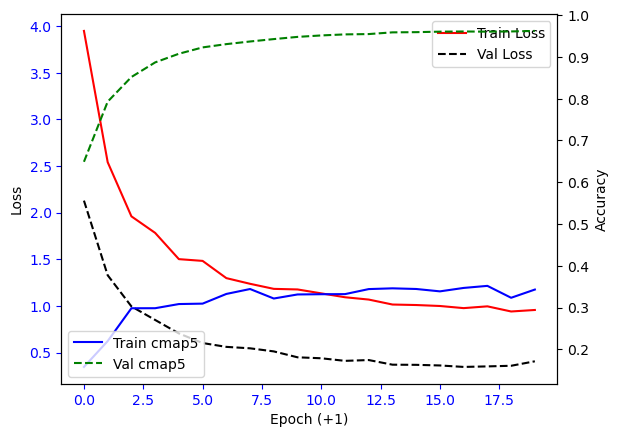

In [28]:
train_losses = [x['train_loss'] for x in metrics]
val_losses = [x['val_loss'] for x in metrics]  
train_precision = [x['train_prec'] for x in metrics]  
val_precision = [x['val_prec'] for x in metrics]  

fig, ax = plt.subplots()
plt.plot(train_losses, 'r', label='Train Loss')
plt.plot(val_losses, '--k', label='Val Loss')
plt.legend()
plt.legend(loc='upper right')
plt.xlabel('Epoch (+1)')
plt.ylabel('Loss')
ax.tick_params('both', colors='r')

# Get second axis
ax2 = ax.twinx()
plt.plot(train_precision, 'b', label='Train cmap5')
plt.plot(val_precision, '--g', label='Val cmap5')
ax2.set_ylabel('Accuracy')
plt.legend()
plt.legend(loc='lower left')
ax.tick_params('both', colors='b')
plt.savefig(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/monitor.jpg')

In [29]:
def plot_by_class(df_target, df_pred):
    cmap5_by_class = padded_cmap_by_class(df_target, df_pred, padding_factor=5)
    col_sums = [(col, df_target[col].sum()) for col in df_target.columns]
    names_by_frequency = sorted(col_sums, key=lambda x: x[1], reverse=True)
    # extract names and counts as separate lists
    names = [name for name, _ in names_by_frequency]
    counts = [count for _, count in names_by_frequency]
    scores = [cmap5_by_class[name] for name in names]
    df = pd.DataFrame({'names': names, 'counts': counts, 'scores': scores})
    df["scores"] = pd.to_numeric(df["scores"])
    df["counts"] = pd.to_numeric(df["counts"])
    fig = px.bar(df, x='scores', y='names', color='counts', orientation='h', hover_data=['counts', 'scores'], range_x=[0, 1])
    fig.update_layout(height=1200)
    fig.show()
    return names, scores,  counts

In [30]:
if in_kaggle:
    pred = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_pred_df.pkl')
    true = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_target_df.pkl')
else:
    pred = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_pred_df.pkl')
    true = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_target_df.pkl')

pred.head()

abethr1   abhori1       abythr1       afbfly1       afdfly1   afecuc1  \
0  0.747559  0.011688  1.040649e-02  1.388550e-03  1.782417e-03  0.008713   
1  0.890625  0.002472  2.269745e-04  1.767874e-04  1.647472e-04  0.000102   
2  0.877441  0.002182  6.145477e-03  1.319885e-03  1.604080e-03  0.001748   
3  0.000504  0.000003  5.960464e-08  5.364418e-07  7.748604e-07  0.000000   
4  0.946289  0.014008  6.027222e-03  9.112358e-04  7.122040e-03  0.003839   

        affeag1       afgfly1       afghor1   afmdov1  ...   yespet1  \
0  1.345634e-03  4.924774e-03  5.889893e-03  0.003990  ...  0.002522   
1  8.106232e-04  3.790855e-05  2.572536e-04  0.000669  ...  0.000045   
2  1.330376e-03  3.030300e-04  1.432419e-03  0.001383  ...  0.000166   
3  3.576279e-07  1.788139e-07  5.960464e-07  0.000004  ...  0.000000   
4  9.002686e-04  1.874924e-03  4.829407e-03  0.004181  ...  0.000548   

    yetgre1       yewgre1   no-call   afpkin1   golher1       lotlap1  \
0  0.000383  3.765106e-03  0.004539  0.008316  0.009270  9.742737e-03   
1  0.000057  3.554821e-04  0.000199  0.000242  0.001399  1.817703e-03   
2  0.000416  2.157211e-03  0.000350  0.000473  0.001294  8.969307e-04   
3  0.000000  8.344650e-07  0.000015  0.000004  0.000000  4.768372e-07   
4  0.000792  8.850098e-03  0.003483  0.002216  0.003124  5.619049e-03   

    rehblu1       whctur2       whhsaw1  
0  0.001174  1.972198e-03  1.214600e-02  
1  0.000128  1.926422e-04  1.499653e-04  
2  0.000504  8.358955e-04  1.934052e-03  
3  0.000000  8.344650e-07  5.960464e-08  
4  0.000624  9.889603e-04  1.846313e-03  

[5 rows x 265 columns]

In [31]:
true.head()

abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  affeag1  afgfly1  \
0      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   afghor1  afmdov1  ...  yespet1  yetgre1  yewgre1  no-call  afpkin1  \
0      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   

   golher1  lotlap1  rehblu1  whctur2  whhsaw1  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0  

[5 rows x 265 columns]

In [32]:
padded_cmap(true, pred, padding_factor = 5)

0.930219517354549

In [33]:
val_names, val_scores, val_counts = plot_by_class(true, pred)
#plt.savefig(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_precision.jpg')

In [34]:
no_call_idx = val_names.index('no-call')
f'There were {val_counts[no_call_idx]} no-calls in the val batch, with a mean cmap5 score of {val_scores[no_call_idx]}'

'There were 17.0 no-calls in the val batch, with a mean cmap5 score of 0.7807218884000048'

In [35]:
padded_cmap(true, pred, padding_factor = 5)      

0.930219517354549

In [36]:
if in_kaggle:
    train_pred = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_pred_df.pkl')
    train_true = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_target_df.pkl')
else:
    train_pred = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_pred_df.pkl')
    train_true = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_target_df.pkl')

In [37]:
train_names, train_scores, train_counts = plot_by_class(train_true, train_pred)
#plt.savefig(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_precision.jpg')

In [38]:
no_call_idx = train_names.index('no-call')
f'There were {train_counts[no_call_idx]} no-calls in the train batch, with a mean cmap5 score of {train_scores[no_call_idx]}'

'There were 95.0 no-calls in the train batch, with a mean cmap5 score of 0.2855413424725663'